# Entropy Monkey (flip the coin)

This is an example strategy how to randomly go all-in to a new token every day.

This is not a real strategy, but an example of different facilities available for the trade: how to construct a trading pair universe, how to integrate with Backtrader, how to check price, how to buy, how to close position.

* The trading universe is SushiSwap pairs on Ethereum mainnet with USD 500k+ all-time buy volume.

* The strategy picks randomly a tokens that have 200k USD volume for the last 7 days.

* This is a simplified example strategy that ignores available liquidity and loss of trade balance due to slippage, currency conversions, etc.

* This is not a Monte-Carlo simulation. The outcome of the strategy depends purely on which seed number you choose to initialise the random number generator. Thus, it not meaningful
  for any real-world comparison.

## Creating trading universe

First let's import libraries and initialise our dataset client.

In [2]:
import matplotlib.figure

try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

from capitalgram.client import Capitalgram

capitalgram = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/moo/.capitalgram


Let's create a pair universe for Sushi. [See full example](https://docs.capitalgram.com/examples/pairs.html).
We will create a dataset of 4h candles that trade on Sushiswap on Ethereum.

In [3]:
import pandas as pd
from capitalgram.chain import ChainId
from capitalgram.pair import PandasPairUniverse

# Decompress the pair dataset to Python map
columnar_pair_table = capitalgram.fetch_pair_universe()

# Exchange map data is so small it does not need any decompression
exchange_universe = capitalgram.fetch_exchange_universe()

# Convert PyArrow table to Pandas format to continue working on it
all_pairs_dataframe = columnar_pair_table.to_pandas()

# Filter down to pairs that only trade on Sushiswap
# and also have (had) some meaningful volume in some point of their life
sushi_swap = exchange_universe.get_by_name_and_chain(ChainId.ethereum, "sushiswap")
sushi_pairs: pd.DataFrame = all_pairs_dataframe.loc[
    (all_pairs_dataframe['exchange_id'] == sushi_swap.exchange_id) &  # Trades on Sushi
    (all_pairs_dataframe['buy_volume_all_time'] > 500_000)  # 500k min buys
]

# Create a Python set of pair ids
wanted_pair_ids = sushi_pairs["pair_id"]

# Make the trading pair data easily accessible
pair_universe = PandasPairUniverse(sushi_pairs)

print(f"Sushiswap on Ethereum has {len(pair_universe.get_all_pair_ids())} legit trading pairs")

Sushiswap on Ethereum has 311 legit trading pairs


Get daily candles and filter them against our wanted pair set.

In [4]:
import datetime

from capitalgram.candle import CandleBucket, GroupedCandleUniverse
from capitalgram.pair import PandasPairUniverse
from capitalgram.frameworks.backtrader import prepare_candles_for_backtrader

# Get daily candles as Pandas DataFrame
all_candles = capitalgram.fetch_all_candles(CandleBucket.d1).to_pandas()
sushi_candles: pd.DataFrame = all_candles.loc[all_candles["pair_id"].isin(wanted_pair_ids)]

sushi_candles = prepare_candles_for_backtrader(sushi_candles)

# We limit candles to a specific date range to make this notebook deterministic
start = datetime.datetime(2020, 10, 1)
end = datetime.datetime(2021, 6, 1)

sushi_candles = sushi_candles[(sushi_candles.index >= start) & (sushi_candles.index <= end)]

# Group candles by the trading pair ticker
sushi_tickers = GroupedCandleUniverse(sushi_candles)

print(f"Candles to feed to the strategy, all pairs is {len(sushi_candles)}")


Candles to feed to the strategy, all pairs is 32457


## Creating the strategy

[See the Backtrader quickstart tutorial](https://www.backtrader.com/docu/quickstart/quickstart/).

### Cumulative volume indicator

We create a [Backtrader indicator based on PeriodN indicator](https://github.com/mementum/backtrader/blob/0fa63ef4a35dc53cc7320813f8b15480c8f85517/backtrader/indicators/basicops.py) how much cumulative trade volume the trading pair has seen in the past. We use this indicator to filter out trading pairs that seem to be dead, as no trading happening, and thus not subject to our random entry.

More information about [Backtrader custom indicators](https://www.backtrader.com/docu/inddev/).

In [5]:
import math
from random import Random

import backtrader as bt
from backtrader.indicators import PeriodN


class PastTradeVolumeIndicator(PeriodN):
    """Indicates whether the trading pair has reached certain volume for the last N days.

    Based on indicator base class that takes period (days) as an input.
    """

    lines = ('cum_volume',)

    params = (('period', 7),)

    def next(self):
        # This indicator is feed with volume line.
        # We simply take the sum of the daily volumes based on the period (number of days)
        datasum = math.fsum(self.data.get(size=self.p.period))
        self.lines.cum_volume[0] = datasum


### Coinflip strategy core

By using the indicator from the above here is our strategy.

In [6]:
from capitalgram.frameworks.backtrader import CapitalgramFeed

class EntropyMonkey(bt.Strategy):
    """A strategy that picks a new token to go all-in every day."""

    def __init__(self, pair_universe: PandasPairUniverse, seed: int):
        #: Allows us to print human-readable pair information
        self.pair_universe = pair_universe

        #: Initialize (somewhat) determininistic random number generator
        self.dice = Random(seed)

        #: We operate on daily candles.
        #: At each tick, we process to the next candle
        self.day = 0

        #: Cumulative volume indicator for each of the data feed
        self.indicators = {}
        pair: CapitalgramFeed
        for pair in self.datas:
            self.indicators[pair] = PastTradeVolumeIndicator(pair.lines.volume)

        # How much USD volume token needs to have in order to be eligible for a pick
        self.cumulative_volume_threshold = 200_000

        # How many times we try to pick a token pair to buy
        # before giving up (at early days there might not be enough volume)
        self.pick_attempts = 100

        # If our balance goes below this considering giving up
        self.cash_balance_death_threshold = 100

    def next(self):
        """Tick the strategy.

        Because we are using daily candles, tick will run once per each day.
        """

        # Advance to the next day
        self.day += 1

        # Pick a new token to buy
        for i in range(self.pick_attempts):
            random_pair: CapitalgramFeed = self.dice.choice(self.datas)
            pair_info = random_pair.pair_info
            cum_volume_indicator = self.indicators[random_pair]
            volume = cum_volume_indicator.lines.cum_volume[0]
            if volume > self.cumulative_volume_threshold and random_pair.close[0] > 0:
                break
        else:
            print(f"On day #{self.day} did not find any token to buy")
            return

        # Sell any existing token we have
        for ticker in self.datas:
             if self.getposition(ticker).size > 0:
                # Too verbose
                # print(f"On day #{self.day}, selling existing position of {pair_info.base_token_symbol} - {pair_info.quote_token_symbol}")
                self.close(ticker)

        # Buy in with all money we have.
        # We are not really worried about order size quantisation in crypto.
        cash = self.broker.get_cash()

        if cash < self.cash_balance_death_threshold:
            # We are busted
            return

        # Buy using the daily candle closing price as the rate
        price = random_pair.close[0]
        assert price > 0, "Pair had zero price "
        size = cash / price

        # Sell the existing position
        print(f"On day #{self.day} we are buying {pair_info.base_token_symbol} - {pair_info.quote_token_symbol} that has 7 days vol of {volume:,.0f} USD. Buy in at price of {price:.4f} USD, cash at hand {cash:,.2f} USD")

        self.buy(random_pair, size=size, exectype=bt.Order.Market)


## Feeding the strategy

Feed our trade data from Sushiswap to the Backtrader strategy.

In [7]:
from capitalgram.frameworks.backtrader import add_dataframes_as_feeds

# Create a cerebro entity
cerebro = bt.Cerebro(stdstats=False)

# Add a strategy
cerebro.addstrategy(EntropyMonkey, pair_universe=pair_universe, seed=0x1000)

# Pass all Sushi pairs to the data fees to the strategy
# noinspection JupyterKernel
feeds = [df for pair_id, df in sushi_tickers.get_all_pairs()]
add_dataframes_as_feeds(
    cerebro,
    pair_universe,
    feeds,
    start,
    end,
    CandleBucket.d1)

## Running the strategy

We are adding some observers that tell us how well the strategy performs.

In [8]:
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

# Run over everything
print('Starting portfolio value: %.2f USD' % cerebro.broker.getvalue())
results = cerebro.run()
print('Ending portfolio value: %.2f USD' % cerebro.broker.getvalue())

strategy: EntropyMonkey = results[0]

Starting portfolio value: 10000.00 USD
On day #1 we are buying COMP - WETH that has 7 days vol of 5,400,299 USD. Buy in at price of 109.9777 USD, cash at hand 10,000.00 USD
On day #2 we are buying SNX - WETH that has 7 days vol of 8,709,391 USD. Buy in at price of 3.9839 USD, cash at hand 10,000.00 USD
On day #3 we are buying LEND - WETH that has 7 days vol of 17,990,044 USD. Buy in at price of 0.4978 USD, cash at hand 10,000.00 USD
On day #4 we are buying WETH - USDT that has 7 days vol of 23,605,109 USD. Buy in at price of 372.3140 USD, cash at hand 10,000.00 USD
On day #5 we are buying LIGHT - WETH that has 7 days vol of 1,862,103 USD. Buy in at price of 69.6684 USD, cash at hand 10,000.00 USD
On day #6 we are buying AMPL - WETH that has 7 days vol of 1,455,346 USD. Buy in at price of 0.8215 USD, cash at hand 114.63 USD
On day #7 we are buying CRO - WETH that has 7 days vol of 266,073 USD. Buy in at price of 0.1398 USD, cash at hand 11,318.23 USD
On day #8 we are buying yyDAI+yUSDC+

## Analysing the portfolio results

In [9]:
print(f"Backtest range {start.date()} - {end.date()}")
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

Backtest range 2020-10-01 - 2021-06-01
Sharpe: -0.628
Norm. Annual Return: -56.21%
Max Drawdown: 89.18%


## Plotting the portfolio value

Below is an example chart how the portfolio value moves over the time.

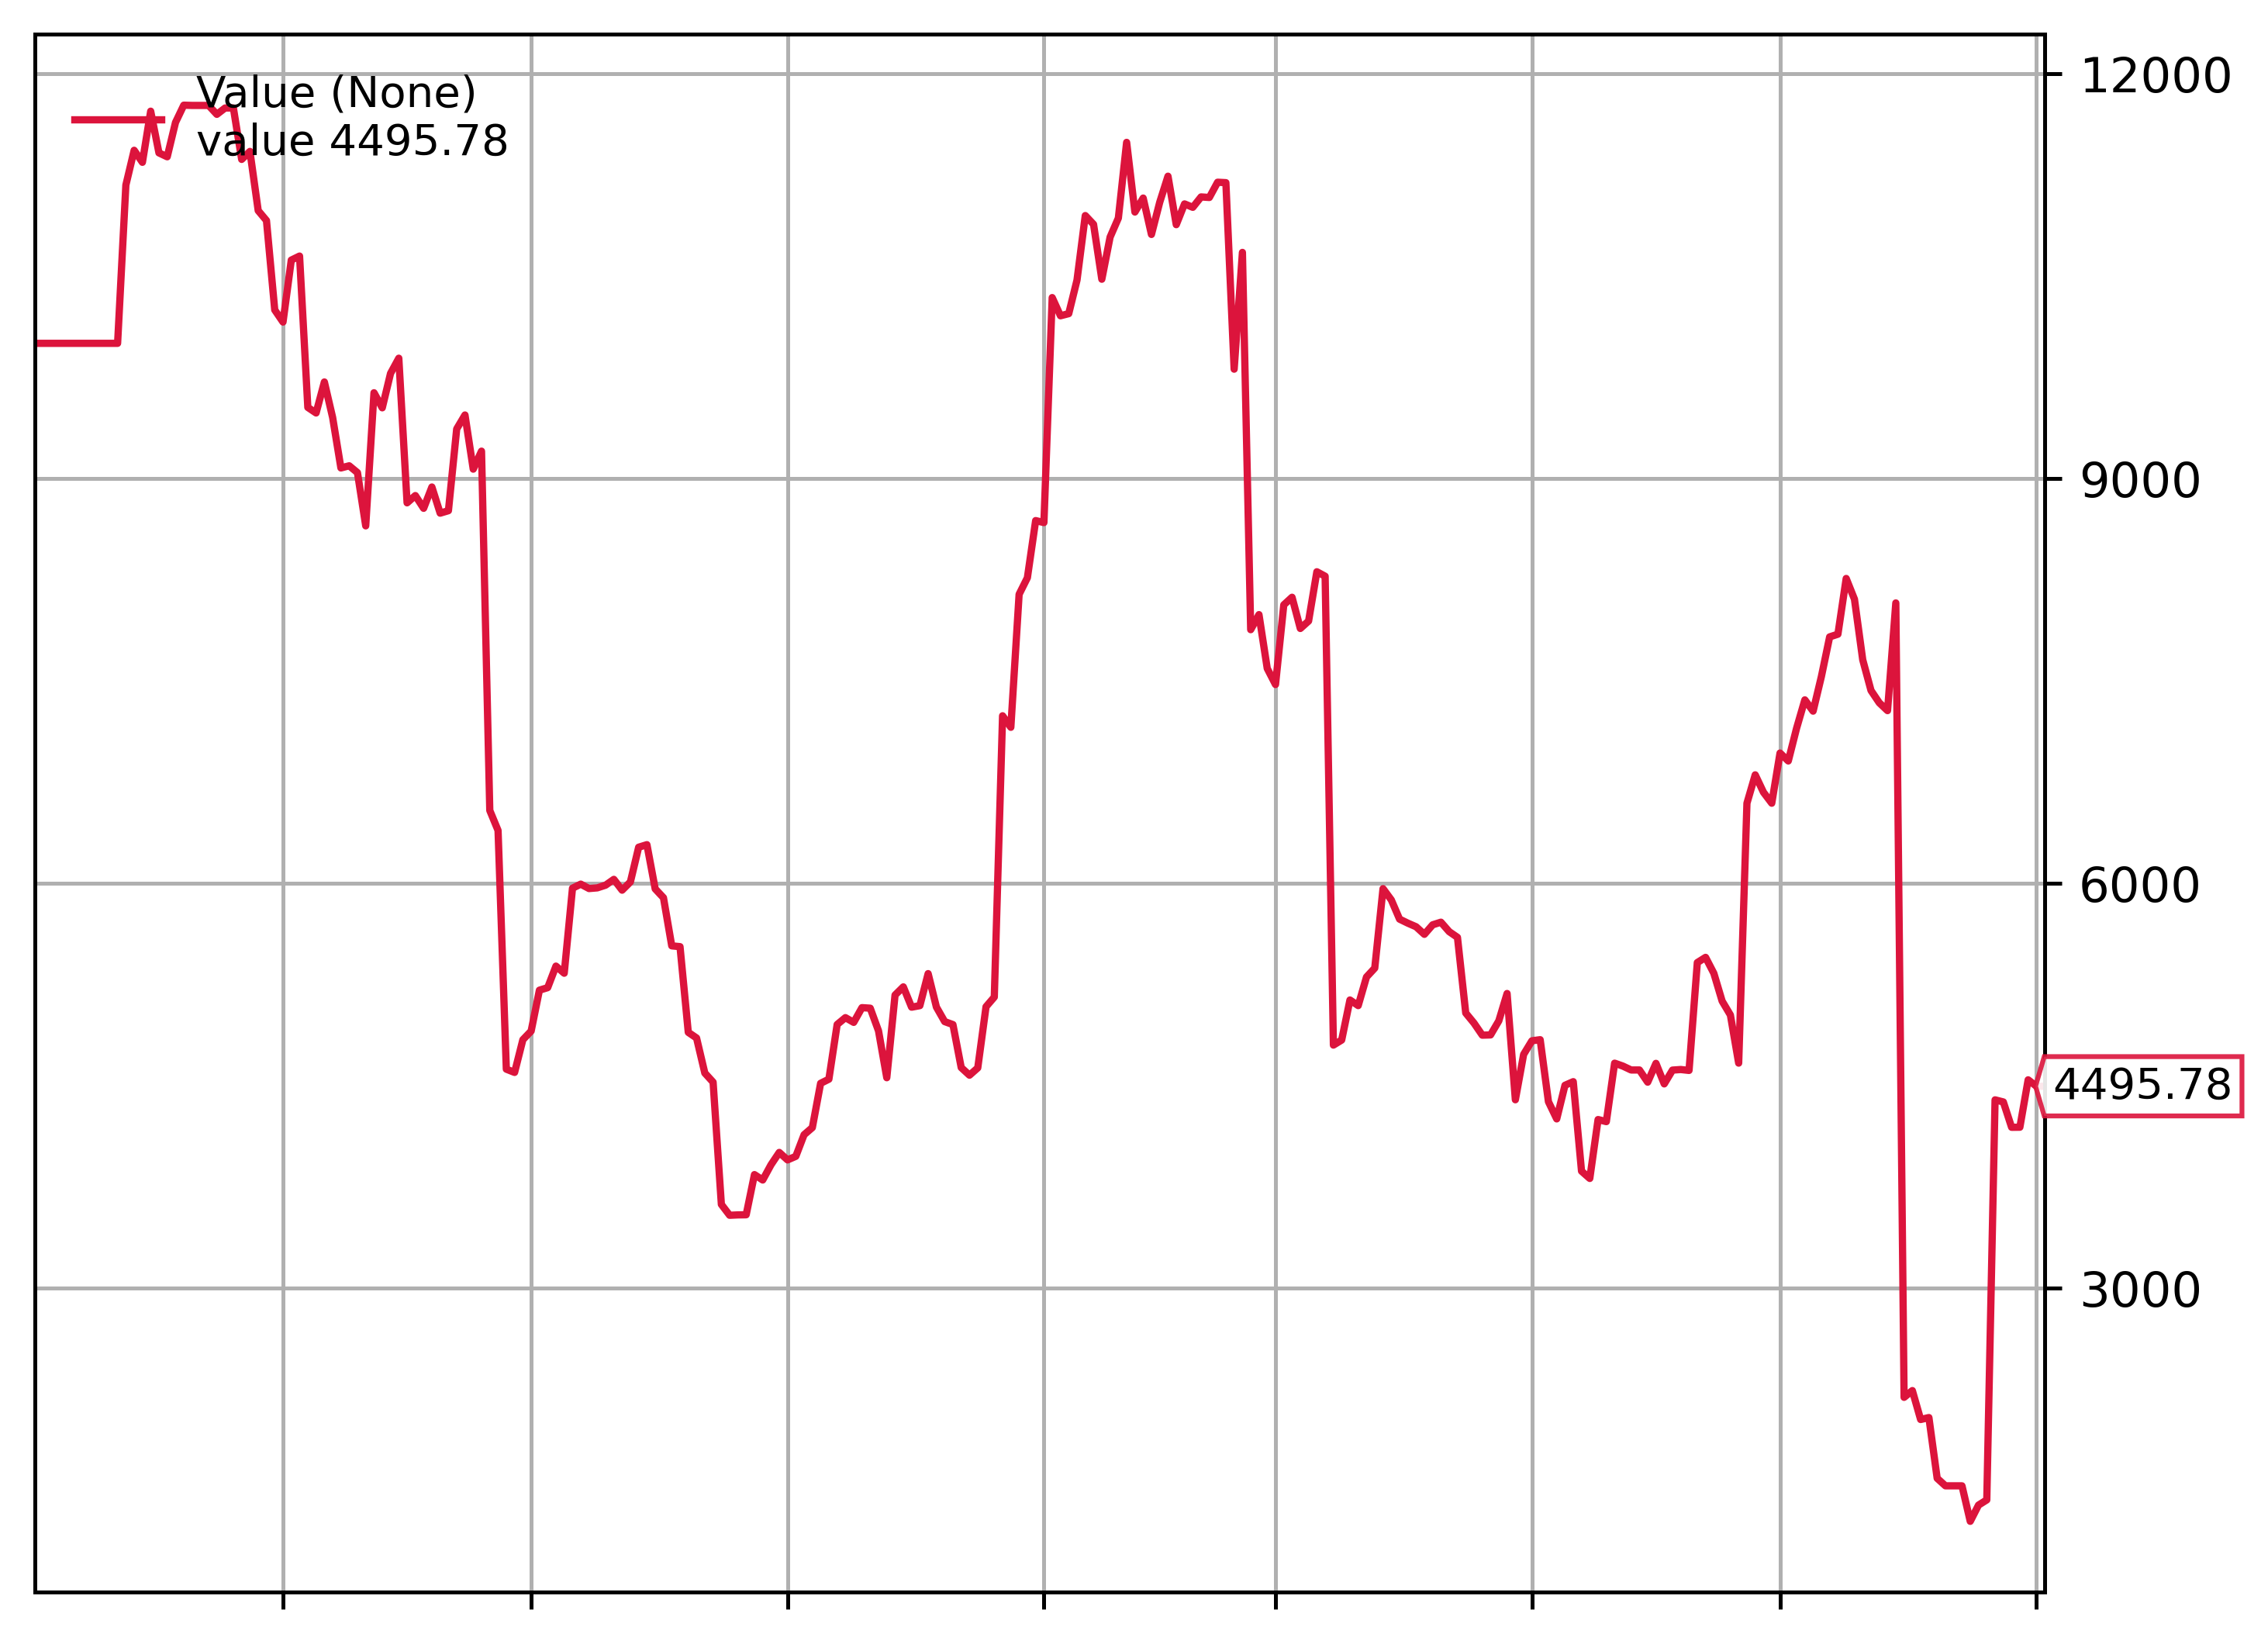

In [10]:
from matplotlib.figure import Figure
from capitalgram.frameworks.matplotlib import render_figure_in_docs

figs = cerebro.plot(iplot=False)

fig: Figure = figs[0][0]

render_figure_in_docs(fig)

That's all this time. Onwards.


